# Homework 6 
## By: Yukun Wan / yw3447

#### This assignment needs to be run under Python 3
#### If under python2, it may have issue when plotting scatter_metrix after run pandas.to_numeric()

In [1]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
import sys    
import statsmodels.formula.api as smf
import statsmodels.api as sm

#s = json.load( open(os.getenv('PUI2016')+'/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)
if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

#reload(sys)  
#sys.setdefaultencoding('utf8')    
    
%pylab inline

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopanda works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


** An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp **

# Import Data

In [2]:
#download, and move data to PUIDATA, and read data in 

os.system('curl -O https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv')
os.system("mv rows.csv " + os.getenv("PUIDATA"))

os.system('curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip')
os.system("mv mn_mappluto_16v2.zip " + os.getenv("PUIDATA"))
os.system("unzip -o " + os.getenv("PUIDATA") + "/mn_mappluto_16v2.zip -d " + os.getenv("PUIDATA") + "/Manhattan")

0

In [3]:
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/rows.csv")
bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/Manhattan/MNMapPLUTO.shp")

In [4]:
nrg.columns

Index(['BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [5]:
bsize.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthArea',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'Address', 'ZoneDist1',
       'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2',
       'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass',
       'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs',
       'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotFront', 'LotDepth',
       'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType',
       'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot',
       'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark',
       'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode', 'BBL',
       'CondoNo', 'Tract2010', 'XCoord', 'YCoord'

In [6]:
# make sure you clean up your data and throw away columns you do not need!

In [7]:
nrg = nrg.drop(['Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Primary Property Type - Self Selected', 
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],axis=1)

In [8]:
bsize = bsize.drop(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthArea',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'Address', 'ZoneDist1',
       'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2',
       'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass',
       'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs',
       'NumFloors', 'LotFront', 'LotDepth',
       'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType',
       'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot',
       'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark',
       'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode', 
       'CondoNo', 'Tract2010', 'XCoord', 'YCoord', 'ZoneMap', 'ZMCode',
       'Sanborn', 'TaxMap', 'EDesigNum', 'APPBBL', 'APPDate', 'PLUTOMapID',
       'Version', 'MAPPLUTO_F', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],axis=1)

In [9]:
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings
Record Number,,,,,
12086,1.000410e+09,NaN,918919,NaN,NaN
14354,4.021460e+09,NaN,NaN,82730.0,1.0
12150,2.027620e+09,NaN,64200,NaN,NaN
12590,1.006700e+09,NaN,NaN,440360.0,1.0
15591,2.048300e+09,NaN,50000,NaN,NaN


In [10]:
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL
0,0,0,1900,1.000010e+09
1,0,0,1987,1.000090e+09
2,500,602,1902,1.000158e+09
3,0,50,1900,1.000130e+09
4,0,0,1900,1.000010e+09


As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

## exploratory analysis

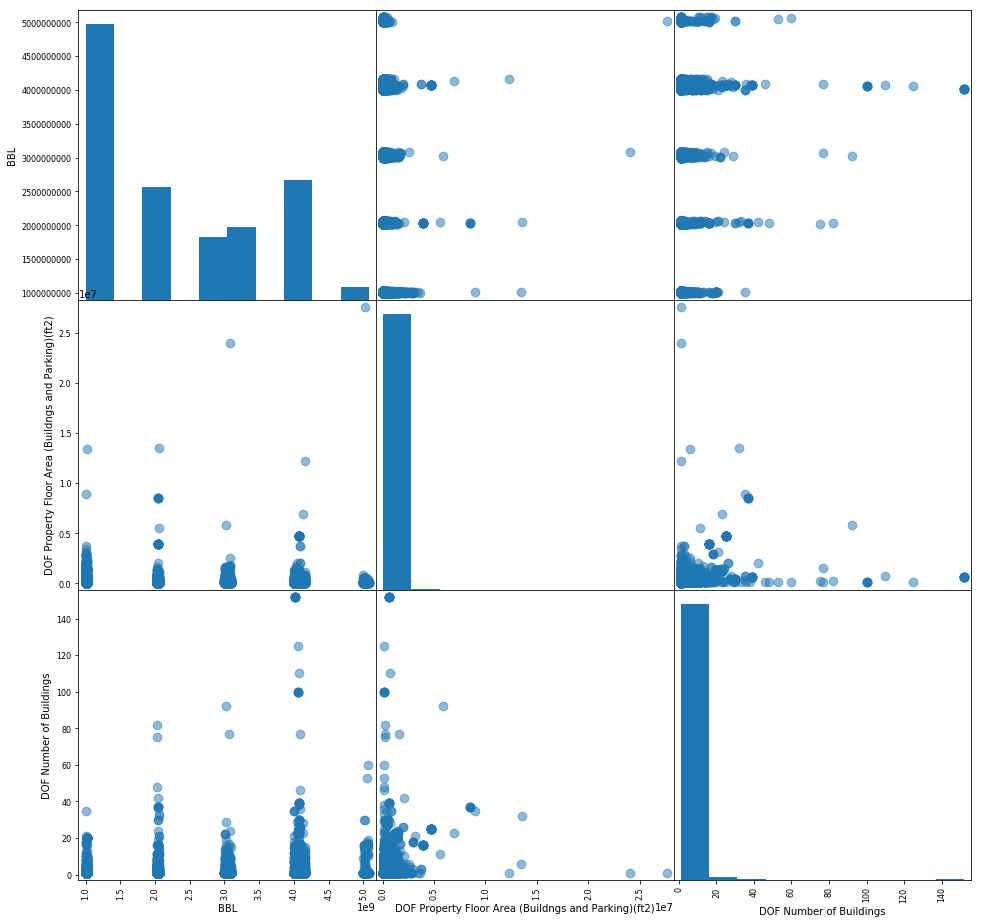

In [11]:
#try make a scatter plot of nrg. Few columns will plot - only those that have numerical values. 
#Pandas will ignore the other ones

from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16));


**Figure 1: scatter matrix of all numerical values in the files of Energy consumption. **

I have five columns in nrg but only three of them displayed. It is because some of the values are not in numeric format. 

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, buy setting it to "coerce". Please look at the function documentation to understand the syntax.

In [12]:
# use pd.to_numeric to convert strings to numeric values, 

for i in nrg.keys():
    nrg[i] = pd.to_numeric(nrg[i],errors='coerce').astype(float)
    #nrg[i].values.encode('utf-8')

for i in bsize.keys():
    bsize[i] = pd.to_numeric(bsize[i],errors='coerce').astype(float)
    #bszie[i].values.encode('utf-8')

##check that your conversion worked: e.g.
#
#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
#bsize.BBL.astype(float)
#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


In [13]:
bsize.keys()

Index(['UnitsRes', 'UnitsTotal', 'YearBuilt', 'BBL'], dtype='object')

In [14]:
nrg.keys()

Index(['BBL', 'Site EUI(kBtu/ft2)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'DOF Number of Buildings'],
      dtype='object')

In [15]:
#How many missing values?
indx = np.isnan(nrg['Site EUI(kBtu/ft2)']).sum()
print ("invalid entries changed to NaN %d"%sum(indx))
#do it for however many columns you need

invalid entries changed to NaN 4623


** MERGE THE DATASETS**
look at the syntax for pandas.merge - this will be incredibly useful to you in all future data problem where you use Pandas and data aggregation is really at the heart of urban science!

TO DO IT WE NEED A COMMON COLUMN: the building id, BBL is in both files. However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. 
You can rename the column, create a whole new column 'BBL' in the energy dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!). YOu can also say pd.merge(..., right_on=BBL, left_on="NYC Borough, Block, and Lot (BBL)'). Always make sure though that the data type is the same! both integers, both strings, or whatever but the same, or you will not be able to merge. 

In [16]:
(bsize.BBL.values[0]), (nrg.BBL.values[0])

(1000010201.0, 1000410001.0)

In [17]:
bblnrgdata = pd.merge(nrg, bsize, on='BBL').dropna()
bblnrgdata.shape

(4688, 8)

In [18]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings,UnitsRes,UnitsTotal,YearBuilt
2,1.013110e+09,125.4,330000.0,313200.0,1.0,0.0,56.0,1977.0
15,1.007660e+09,122.3,59468.0,53168.0,1.0,0.0,8.0,1912.0
16,1.008150e+09,117.0,364000.0,364000.0,1.0,0.0,24.0,1954.0
18,1.005050e+09,82.1,235370.0,214110.0,1.0,0.0,24.0,1926.0
19,1.021420e+09,137.7,64806.0,64816.0,1.0,54.0,62.0,1924.0


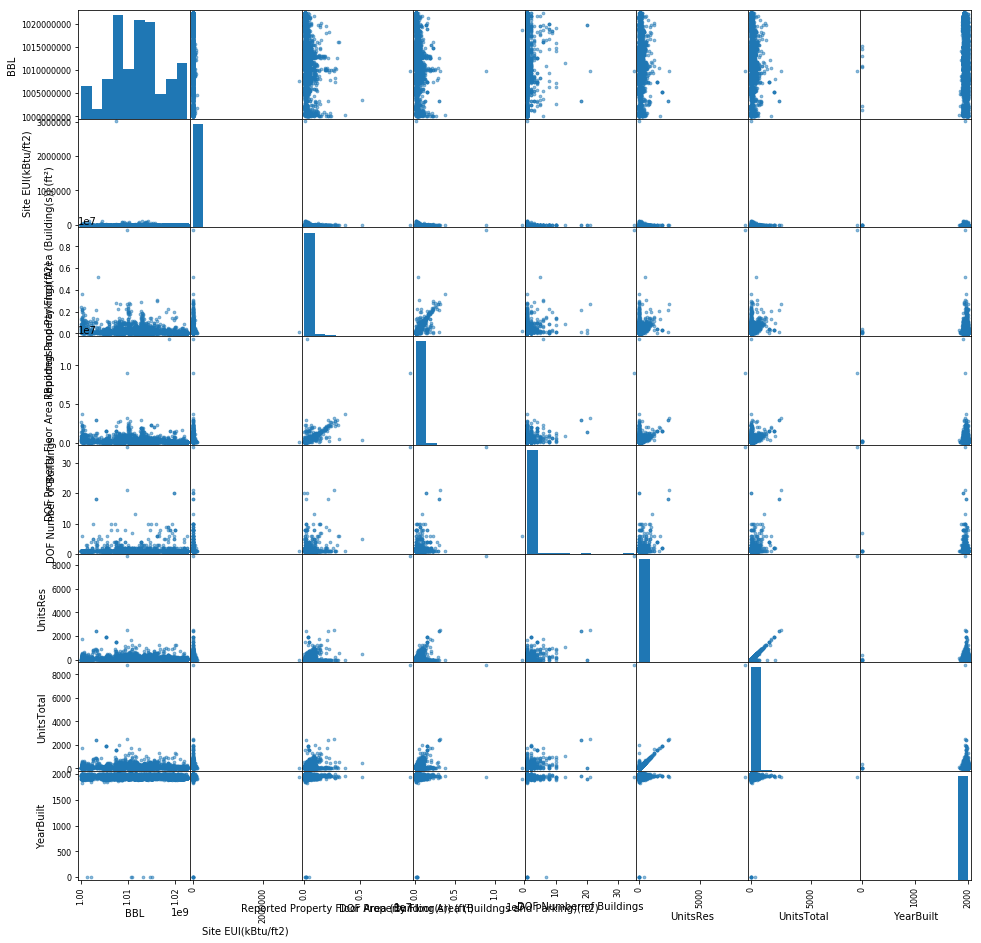

In [19]:
scatter_matrix(bblnrgdata, s=30, figsize=(16, 16));

**Figure 2: scatter matix of final dataset**
All the columns are plotted because they are changed to numeric format.

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building.  **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

In [20]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings,UnitsRes,UnitsTotal,YearBuilt
2,1.013110e+09,125.4,330000.0,313200.0,1.0,0.0,56.0,1977.0
15,1.007660e+09,122.3,59468.0,53168.0,1.0,0.0,8.0,1912.0
16,1.008150e+09,117.0,364000.0,364000.0,1.0,0.0,24.0,1954.0
18,1.005050e+09,82.1,235370.0,214110.0,1.0,0.0,24.0,1926.0
19,1.021420e+09,137.7,64806.0,64816.0,1.0,54.0,62.0,1924.0


In [21]:
# first scatter plot

bblnrgdata['Total energy consumption'] = bblnrgdata['Site EUI(kBtu/ft2)'] * bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)']

Text(0,0.5,'Number of Units')

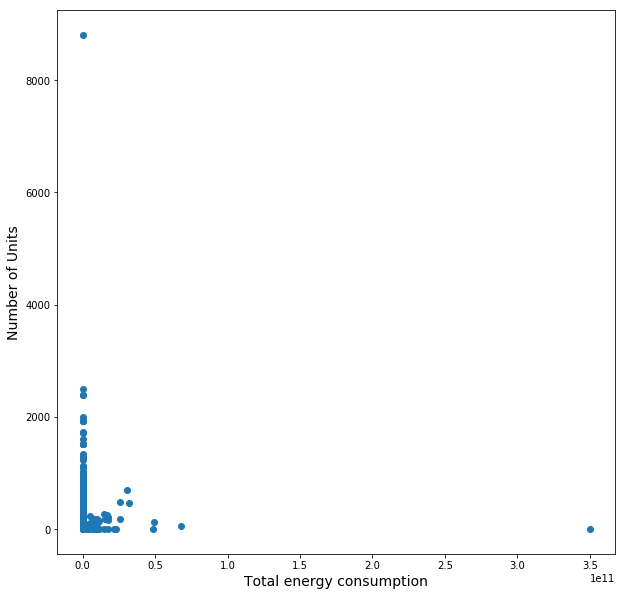

In [22]:
fig = pl.figure(figsize=(10,10)) 
pl.plot(bblnrgdata['Total energy consumption'],bblnrgdata['UnitsTotal'],'o')
pl.xlabel('Total energy consumption',size=14)
pl.ylabel('Number of Units',size=14)

**Figure 3: Original plotting total energy consumption against number of units.**

Most of points are in the left bottom corner. It shows badly because there is one point with unit number up to 8000.


(1, 1000)

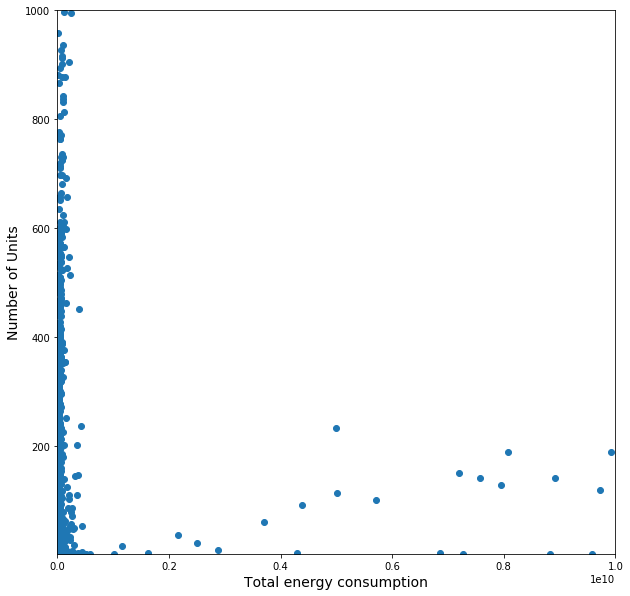

In [23]:
# zoomed in scatter plot

fig = pl.figure(figsize=(10,10)) 
pl.plot(bblnrgdata['Total energy consumption'],bblnrgdata['UnitsTotal'],'o')
pl.xlabel('Total energy consumption',size=14)
pl.ylabel('Number of Units',size=14)
pl.xlim(1000,1e10)
pl.ylim(1,1000)

**Figure 4: zoomed plotting total energy consumption against number of units.**

After zoomed, the plotting became clearer. Most of points are on the left side and range from 0 to 200 in number of units.

** IMPORTANT NOTE ABOUT LOGS AND LOG PLOTS **
in class we talked about logs when we talked about likelihood: often we prefer working with the log(likelihood) instead of the likelihood, and since all problems involving likelihood are about maximization (find the maximum likelihood to find the best fit parameters) and the log is a MONOTONIC function (log(x) grows when x grows, and gets smaller when x gets smaller) the maximum of the likelihood of a model with be in the same place as the maximum of the log(likelihood). 

Another great thing about logarithm: **when the points in a plot all look scrunched against the axis **


**Try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

This will compress the high  x and high  y values, and compress the small x and small y values. 



NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

Also I removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.



In [24]:
#you may need to change the name of this column under some versions of pandas
bblnrgdata['Reported Property Floor Area (Building(s))'] = \
            pd.to_numeric(bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'], 
                          errors='coerce').astype(float)

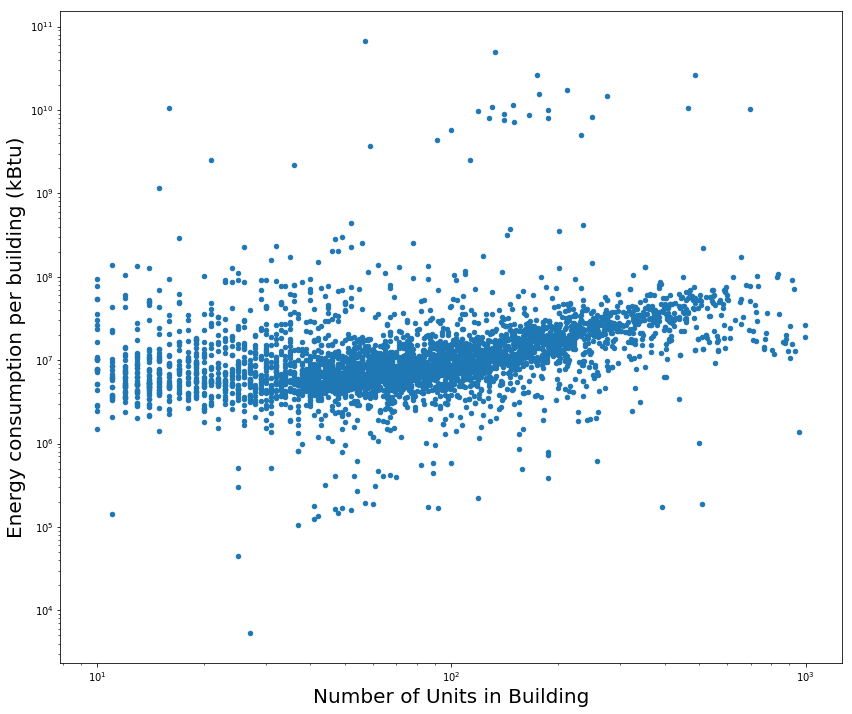

In [25]:
#the line below checks that the conversion worked. should be removed in delivery ready ipynb
#nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)#log plot
bblnrgdata['nrg'] = bblnrgdata['Total energy consumption'] / bblnrgdata['DOF Number of Buildings']

bblnrgdataCut = bblnrgdata[(bblnrgdata.nrg > 1000) & (bblnrgdata.UnitsTotal>=10) & 
                           (bblnrgdata.UnitsTotal<1000)]

ax = bblnrgdataCut.plot(kind='scatter', y='nrg', x='UnitsTotal', 
                   marker='o',  figsize=(14, 12), loglog=True)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

**Figure 5: Plotting number of units in building against energy consumption per building in log space**

After log the x and y and remove the outlier, the ploting shows more clear. Energy consumption per building (kBtu) is concentrated between 10^5 and 10^8


Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:


In [26]:
#x = bblnrgdataCut.UnitsTotal
#y = bblnrgdataCut.nrg

#X = sm.add_constant(np.log10(x))
#linmodel = sm.OLS(np.log10(y), X, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN

## choose  which is your DEPENDENT and which is your INDEPENDENT variable. 
which is the "logical" IV: what are we assuming depends on what? energy on size of building or building on size of energy... discuss this but also test both fits, energy vs size and size vs energy. how can you compare these models? 

I WILL UPLOAD SOME MORE INSTRUCTIONS TONIGHT



1. **Fit a line** to Units vs Energy. The independent variable in this problem should be number of units, but try fit both Unity to energy and energy to unit.
2. **Fit a line** to Energy vs Units.
3. **Evaluate which is better by calculating the chi square**.  Can you compare these models with the likelihood ratio test? (hint: are they nested??) I provide a function to calculate the chi square or you can write your own.

    The function is :
    
    chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
    where the sum is over all datapoints, 
    
    for the i-th value  model($x_i$) is the prediction, data($x_i$) the observation,
    
    and $error_i$ is $\sqrt{data(x_i)}$
    (but remember you worked in log space! What are the proper errors?? see next point)
    
4. *Assume Poisson statistics* for the errors on the *independent variable*. Poisson statistics means your uncertainty is the square root of your measurement. I wrote down the formula for the errors. Please explain why I wrote it as I did.

5. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2 + bx + c$ .

6. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * log(Likelihood_Model1 / Likelihood_Model2) 

    or equivalently
        
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2) 
    
    where Model1 is the _least complex_ (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels. (Model1.llf)
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferable to Model2. The LR is chi^2 distributed with number of degrees of freedom $N_{DOF}$ = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))



## 1. Fit line to Units vs Energy: The independent variable is number of units

Text(0,0.5,'Total energy consumption')

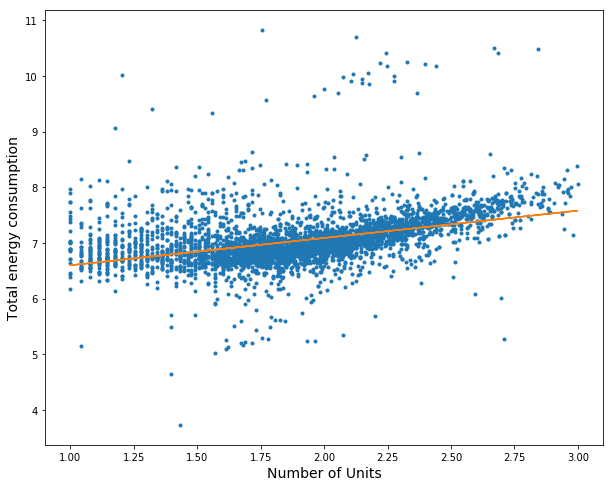

In [27]:
# fits and plots here
# your plots should show datapoints (as scatter plot) and models (as lines)

x = bblnrgdataCut['UnitsTotal']
y = bblnrgdataCut['Total energy consumption']

X = sm.add_constant(np.log10(x))
lm1 = sm.OLS(np.log10(y), X, missing='drop').fit() 

fig = pl.figure(figsize=(10,8)) 
pl.plot(np.log10(x),np.log10(y),'.')
pl.plot(np.log10(x),lm1.predict())
pl.xlabel('Number of Units',size=14)
pl.ylabel('Total energy consumption',size=14)

**Figure 6: Fit a line to Units vs Energy: The independent variable is Number of units**

## 2. Fit line to Energy vs Units: The independent variable is Total Energy Consumption

Text(0,0.5,'Number of Units')

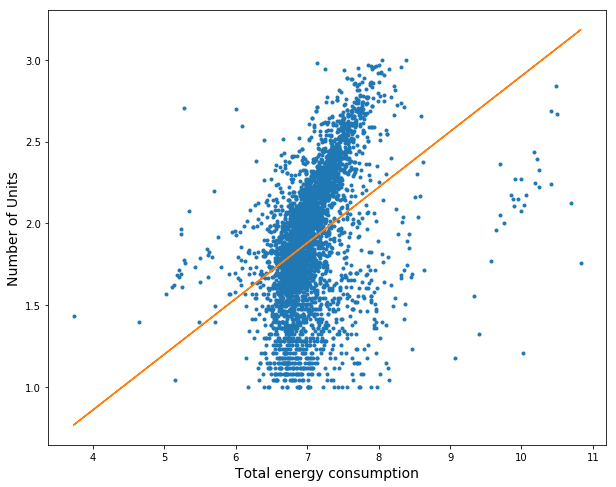

In [28]:
x = bblnrgdataCut['Total energy consumption']
y = bblnrgdataCut['UnitsTotal']

X = sm.add_constant(np.log10(x))
lm2 = sm.OLS(np.log10(y), X, missing='drop').fit() 

fig = pl.figure(figsize=(10,8)) 
pl.plot(np.log10(x),np.log10(y),'.')
pl.plot(np.log10(x),lm2.predict())
pl.xlabel('Total energy consumption',size=14)
pl.ylabel('Number of Units',size=14)

**Figure 7: Fit line to Energy vs Units: The independent variable is Total Energy Consumption**

## 3. Evaluate which is better by calculating the chi square

Can you compare these models with the likelihood ratio test? (hint: are they nested??)

Ans: No, they are not nested. So we cannot compare them with likelihood ratio test

In [29]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [30]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#Below I am writing out some uncertainties - please explain the functional form that I used.
#errors on the measured quantities
errorsnrg = np.sqrt((bblnrgdataCut['Reported Property Floor Area (Building(s))'])**2 +\
                (bblnrgdataCut['Site EUI(kBtu/ft2)']**2))

## Assume count statistics in the number of units as well
errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)

#These errors need to be propagated properly through the log


propagation of errors on the log:https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [31]:
errorsInLogNrg = np.abs(errorsnrg / bblnrgdataCut.nrg / np.log(10))
errorsInLogUnits = np.abs(errorsunits / bblnrgdataCut.UnitsTotal / np.log(10))

bblnrgdataCut['errorsnrg'] = errorsInLogNrg
bblnrgdataCut['errorsunits'] = errorsInLogUnits

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
bblnrgdataCut.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings,UnitsRes,UnitsTotal,YearBuilt,Total energy consumption,Reported Property Floor Area (Building(s)),nrg,errorsnrg,errorsunits
2,1.013110e+09,125.4,330000.0,313200.0,1.0,0.0,56.0,1977.0,41382000.0,330000.0,41382000.0,0.003463,0.058035
16,1.008150e+09,117.0,364000.0,364000.0,1.0,0.0,24.0,1954.0,42588000.0,364000.0,42588000.0,0.003712,0.088650
18,1.005050e+09,82.1,235370.0,214110.0,1.0,0.0,24.0,1926.0,19323877.0,235370.0,19323877.0,0.005290,0.088650
19,1.021420e+09,137.7,64806.0,64816.0,1.0,54.0,62.0,1924.0,8923786.2,64806.0,8923786.2,0.003154,0.055155
20,1.021750e+09,103.2,62839.0,62847.0,1.0,75.0,85.0,1920.0,6484984.8,62839.0,6484984.8,0.004208,0.047106


In [33]:
chilm1 = chi2(np.log10(bblnrgdataCut['Total energy consumption']),lm1.predict(),bblnrgdataCut.errorsnrg)
chilm2 = chi2(np.log10(bblnrgdataCut['UnitsTotal']),lm2.predict(),bblnrgdataCut.errorsunits)

print("chi-square for lm1: {}\nchi-square for lm2: {}".format(chilm1,chilm2))

chi-square for lm1: 2877099024119.33
chi-square for lm2: 444696.3027045577


**chi-square statistics for the second model is closer to 1. So we can say that the second model (The independent variable is Total Energy Consumption) is better than the first model. (actually both models are not good enough)**

## 4. Explain why error is calculated like this.
Because we use Poisson statistics for the errors on the independent variable. Poisson statistics means your uncertainty is the square root of your measurement. And for Energy Total Consumption, it is calculated by multipling Reported Property Floor Area (Building(s)) with Site EUI(kBtu/ft2). So when calculating the error for Energy Total Consumption, we need to calcualte the error for both Reported Property Floor Area (Building(s)) and Site EUI(kBtu/ft2) and then calculate the square root of the sum of their squares.

## 5. Fit a 2nd degree polynomial

In [34]:
x = np.log10(bblnrgdataCut['UnitsTotal'])
y = np.log10(bblnrgdataCut['Total energy consumption'])
df = pd.DataFrame({'x':x,'y':y,'x2':x*x})
df.head()

,x,x2,y
2,1.748188,3.056161,7.616811
16,1.380211,1.904983,7.629287
18,1.380211,1.904983,7.286094
19,1.792392,3.212668,6.950549
20,1.929419,3.722657,6.811909


In [35]:
lm3 = smf.ols(formula='y ~ x2 + x',data=df).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     603.4
Date:                Mon, 04 Dec 2017   Prob (F-statistic):          1.12e-229
Time:                        14:12:21   Log-Likelihood:                -2161.6
No. Observations:                3992   AIC:                             4329.
Df Residuals:                    3989   BIC:                             4348.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.1337      0.115     70.892      0.000         7.909     8.359
x2             0.5824      0.032     18.399      0.000         0.520     0.645
x             -1.7302      0.122    -14.198      0.000        -1.969    -1.491
==============================================================================
Omnibus:                     2363.734   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65676.793
Skew:                           2.316   Prob(JB):                         0.00
Kurtosis:                      22.323   Cond. No.                         118.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0,0.5,'Total energy consumption')

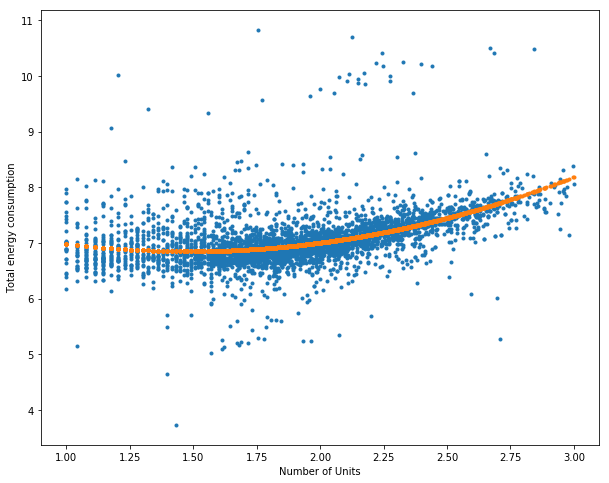

In [36]:
fig = pl.figure(figsize=(10,8)) 
pl.plot(df.x,df.y,'.')

pl.plot(df.x,lm3.predict(),'.')
pl.xlabel('Number of Units')
pl.ylabel('Total energy consumption')

**Figure 8: Fit a 2nd degree polynomial to the Units vs Energy**
It seems to be more fittable in 2nd degree model.

## 6. Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test.

In [37]:
print ("LR : ", -2 * (lm1.llf - lm3.llf))
print ("LR from statsmodels: {}".format(lm3.compare_lr_test(lm1)))

LR :  325.157988067
LR from statsmodels: (325.15798806713883, 1.0899519200199688e-72, 1.0)


**null hypothesis: complex model is not better than simple model**

**significance level = 0.05**

**Likelihood Ratio statistcs = 325.15, p-value = 1.0899519200199688e-72. p-value is less than critical value 0.05, which means that null hypothesis is rejected**

## Extra credit 1: calculate and plot the likelihood surface
Create a function that minimizes the residuals:

the residuals are the sum of the differences between data and model: in the case of a line fit model. Use the same function you created for the chi^2 test.

You should sum over each datapoints the residuals squared, which should look something like

(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2 / errors^2

where a and b are the parameters returned by the line fitter. 

For each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope.


You can write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a,b,data,errors)) .....

this gives you a 2D array that represents your likelihood surface! What we do to find a good fit is find the minimum (lowest point) on this surface.
You can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap" but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface)). Also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. Inputting your data in the cell below should give a plot similar to mine

In [38]:
def residuals(a,b,errors):
    return np.nansum((np.log10(bblnrgdataCut.nrg) - np.log10(bblnrgdataCut.UnitsTotal)*a+b )**2 / errors**2)

A = np.arange(-50.0, 50.0, 0.5)
B = np.arange (-100, 100, 1) 
errors = np.sqrt(np.log10(bblnrgdataCut.nrg))
Lsurface = np.zeros((len(A), len(B))) 
for i,a in enumerate(A): 
    for j,b in enumerate(B): 
        Lsurface[i][j] = residuals(a,b,errors)

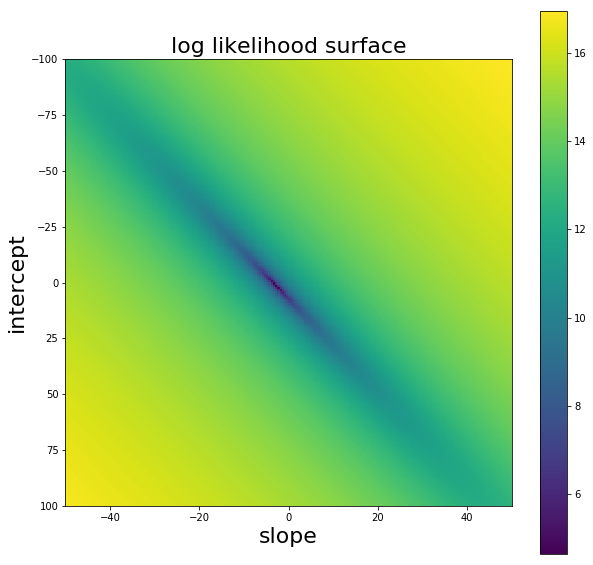

In [39]:
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

below I am mapping the building age to a colormap and the ratio of total to residential units to the size of the datapoint.

Text(0.5,0,'total energy consumption (kBtu)')

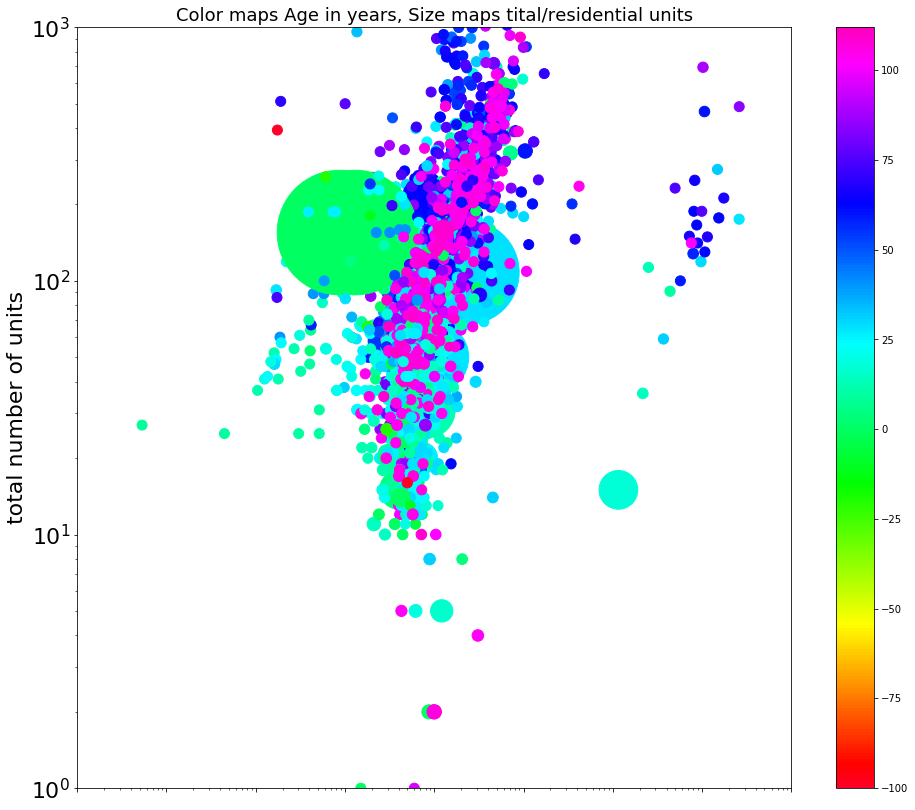

In [40]:
bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=bblnrgdata['YearBuilt']-1900, 
                s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)

Grade: 10/10 